In [1]:
import os
print(os.getcwd())

/home/jupyter-bryan/ISA_Data


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LayerNormalization, Bidirectional, LSTM, GRU, Layer, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Lambda, Reshape, Flatten, Input, MultiHeadAttention, Flatten, Concatenate, Add, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random
import torch

2025-12-15 19:29:48.894920: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def clean_and_interpolate(data):
    df = pd.DataFrame(data).astype(np.float32)
     
    df_linear = df.interpolate(method='linear', limit_direction='both', axis=1, limit=None)
    df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

    df_final = df_spline.fillna(0)
    
    # Clip extreme values
    df_interpolated_fin = df_final.clip(-1e6, 1e6)
    print(f"Final NaN count: {df_interpolated_fin.isnull().sum().sum()}")
    result = df_interpolated_fin.values
    
    return result

In [5]:
def prepare_multi_region_data(ph_paths, kor_paths, cbr_paths):
    def load_region_data(paths):
        # Load all dataframes for a region
        ndvi_df = pd.read_csv(paths['ndvi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        mndwi_df = pd.read_csv(paths['mndwi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        ndbi_df = pd.read_csv(paths['ndbi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        ndbsi_df = pd.read_csv(paths['ndbsi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        cbi_df = pd.read_csv(paths['cbi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        uci_df = pd.read_csv(paths['uci'],delimiter=';', encoding='utf-8-sig',decimal=',')
        print('NDVI shape before int:', ndvi_df.shape)
        
        # Extract features
        ndvi_features = ndvi_df.iloc[:,5:29].values
        mndwi_features = mndwi_df.iloc[:,5:29].values
        ndbi_features = ndbi_df.iloc[:,5:29].values
        ndbsi_features = ndbsi_df.iloc[:,5:29].values
        cbi_features = cbi_df.iloc[:,5:29].values
        uci_features = uci_df.iloc[:,5:29].values
        print('NDVI shape after int:', ndvi_features.shape)
        
        # Clean and interpolate
        ndvi_features = clean_and_interpolate(ndvi_features)
        mndwi_features = clean_and_interpolate(mndwi_features)
        ndbi_features = clean_and_interpolate(ndbi_features)
        ndbsi_features = clean_and_interpolate(ndbsi_features)
        cbi_features = clean_and_interpolate(cbi_features)
        uci_features = clean_and_interpolate(uci_features)
        
        # Combine features
        X = np.concatenate([ndvi_features, mndwi_features, ndbi_features, 
                            ndbsi_features, cbi_features, uci_features], axis=1)

        print("X afer concatenate", X.shape)
        
        # Reshape
        X = X.reshape(X.shape[0], 24, 6)
        print("X afer reshape", X.shape)
        
        # Get labels, slope and aspect
        labels = ndvi_df.iloc[:, 1].values
        slope_values = ndvi_df.iloc[:,29].values
        aspect_values = ndvi_df.iloc[:,30].values
        
        # return X, labels, slope_values
        return X, labels, slope_values, aspect_values

    # Load data for both regions
    X_ph, labels_ph, slope_ph, elev_ph = load_region_data(ph_paths)
    X_kor, labels_kor, slope_kor, elev_kor = load_region_data(kor_paths)
    X_cbr, labels_cbr, slope_cbr, elev_cbr = load_region_data(cbr_paths)
    
    # Combine data from both regions
    X_combined = np.concatenate([X_ph, X_kor, X_cbr], axis=0)
    labels_combined = np.concatenate([labels_ph, labels_kor, labels_cbr])
    slope_combined = np.concatenate([slope_ph, slope_kor, slope_cbr])
    elev_combined = np.concatenate([elev_ph, elev_kor, elev_cbr])
    
    # Compute class weights on combined data
    unique_classes = np.unique(labels_combined)

    print("Labels combined shape:", labels_combined.shape)
    print("Labels combined type:", type(labels_combined[0]) if len(labels_combined) > 0 else "Empty")
    print("Unique classes from np.unique:", unique_classes)
    print("Unique classes type:", type(unique_classes[0]) if len(unique_classes) > 0 else "Empty")
    print("All unique values in labels_combined:", set(labels_combined))
    print("Any NaN values?", np.any(pd.isna(labels_combined)))

    # Check if there are any labels in y that aren't in classes
    missing_labels = set(labels_combined) - set(unique_classes)
    print("Labels in y but not in classes:", missing_labels)
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=labels_combined)
    
    class_weight_dict = dict(enumerate(class_weights))
    print("Class weights:", class_weight_dict)
    
    y = np.asarray(labels_combined)
    print(y)
    print(len(np.unique(y)))
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_combined = label_encoder.fit_transform(labels_combined)
    y_combined = to_categorical(y_combined)
    print(y_combined)
    
    # Split combined data
    X_train, X_test, y_train, y_test, slope_train, slope_test, elev_train, elev_test = train_test_split(X_combined, y_combined,
                                                                                                            slope_combined, elev_combined,
                                                                                                            test_size=0.3,random_state=42,
                                                                                                            stratify=y_combined)
    
    # Convert slope values to tensorflow constant
    slope_train = tf.constant(slope_train, dtype=tf.float32)
    slope_test = tf.constant(slope_test, dtype=tf.float32)

    # Convert aspect values to tensorflow constant
    elev_train = tf.constant(elev_train, dtype=tf.float32)
    elev_test = tf.constant(elev_test, dtype=tf.float32)
    
    return (X_train, X_test, y_train, y_test, label_encoder, class_weight_dict, slope_train, slope_test, elev_train, elev_test, y)

In [6]:
ph_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/PH_FineTune_NDVI.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/PH_FineTune_MNDWI.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/PH_FineTune_NDBI.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/PH_FineTune_NDBSI.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/PH_FineTune_CBI.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/PH_FineTune_UCI.csv'
}

kor_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/KOR_FineTune_NDVI.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/KOR_FineTune_MNDWI.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/KOR_FineTune_NDBI.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/KOR_FineTune_NDBSI.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/KOR_FineTune_CBI.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/KOR_FineTune_UCI.csv'
}

cbr_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/CBR_FineTune_NDVI.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/CBR_FineTune_MNDWI.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/CBR_FineTune_NDBI.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/CBR_FineTune_NDBSI.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/CBR_FineTune_CBI.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/CBR_FineTune_UCI.csv'
}

# Prepare the combined data
X_train, X_test, y_train, y_test, label_encoder, class_weight_dict, slope_train, slope_test, elev_train, elev_test, y = prepare_multi_region_data(ph_paths, 
                                                                                                                                                  kor_paths, 
                                                                                                                                                  cbr_paths)

NDVI shape before int: (400, 31)
NDVI shape after int: (400, 24)
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
X afer concatenate (400, 144)
X afer reshape (400, 24, 6)
NDVI shape before int: (310, 31)
NDVI shape after int: (310, 24)
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
X afer concatenate (310, 144)
X afer reshape (310, 24, 6)


/tmp/ipykernel_1519703/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1519703/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1519703/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1519703/1661099113.py:5: FutureWarning: DataFrame.fillna with

NDVI shape before int: (334, 31)
NDVI shape after int: (334, 24)
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
X afer concatenate (334, 144)
X afer reshape (334, 24, 6)
Labels combined shape: (1044,)
Labels combined type: <class 'numpy.int64'>
Unique classes from np.unique: [1 2 3 4 5]
Unique classes type: <class 'numpy.int64'>
All unique values in labels_combined: {np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)}
Any NaN values? False
Labels in y but not in classes: set()
Class weights: {0: np.float64(0.5105134474327628), 1: np.float64(1.2968944099378883), 2: np.float64(0.9942857142857143), 3: np.float64(1.5938931297709924), 4: np.float64(1.5699248120300753)}
[3 3 3 ... 4 4 4]
5
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


/tmp/ipykernel_1519703/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1519703/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1519703/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1519703/1661099113.py:5: FutureWarning: DataFrame.fillna with

In [7]:
# def swish(x, beta = 1):
#     return (x * sigmoid(beta * x))

# tf.keras.utils.get_custom_objects().update({'swish': swish})

# def ReshapeLayer(x):
#     shape = x.shape
#     # 1 possibility: H,W*channel
#     reshape = Reshape((shape[1],shape[2]))(x)
#     # 2 possibility: W,H*channel
#     # transpose = Permute((2,1,3))(x)
#     # reshape = Reshape((shape[1],shape[2]*shape[3]))(transpose)
#     return reshape

In [8]:
model_path = '/home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_LWCNN.keras'
model = load_model(model_path,
                   compile=False)

# Then recompile with your custom loss
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_LWCNN_FineTune.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='max')

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=100,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.1,
                              patience=30, 
                              min_lr=0.00001)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size =20,
                    epochs=500, 
                    callbacks = [checkpoint, early_stop, reduce_lr], 
                    class_weight = class_weight_dict)

Epoch 1/500


2025-12-15 19:29:56.330262: I external/local_xla/xla/service/service.cc:163] XLA service 0x7eddcc0031c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-15 19:29:56.330279: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-12-15 19:29:56.389507: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-15 19:29:56.826469: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-12-15 19:29:57.710898: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1206', 56 bytes spill stores, 56 bytes spill loads

2025-12-15 19:29:57.767807: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas 

23/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5652 - loss: 6.7952 

I0000 00:00:1765798200.781607 1521244 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-12-15 19:30:01.988025: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1206', 4 bytes spill stores, 4 bytes spill loads



37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5610 - loss: 6.5460

2025-12-15 19:30:05.822968: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_235', 4 bytes spill stores, 4 bytes spill loads




Epoch 1: val_accuracy improved from None to 0.58917, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_LWCNN_FineTune.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.5603 - loss: 5.9159 - val_accuracy: 0.5892 - val_loss: 3.8715 - learning_rate: 1.0000e-04
Epoch 2/500
21/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6585 - loss: 4.3267 
Epoch 2: val_accuracy improved from 0.58917 to 0.64650, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_LWCNN_FineTune.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6479 - loss: 3.7355 - val_accuracy: 0.6465 - val_loss: 3.0512 - learning_rate: 1.0000e-04
Epoch 3/500
21/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6620 - loss: 2.5086 
Epoch 3: val_accuracy improved from 0.64650 to 0.69108, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_LWCNN_FineTune.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6849 - loss: 2.7618 - val_accuracy: 0.6911 - val_loss

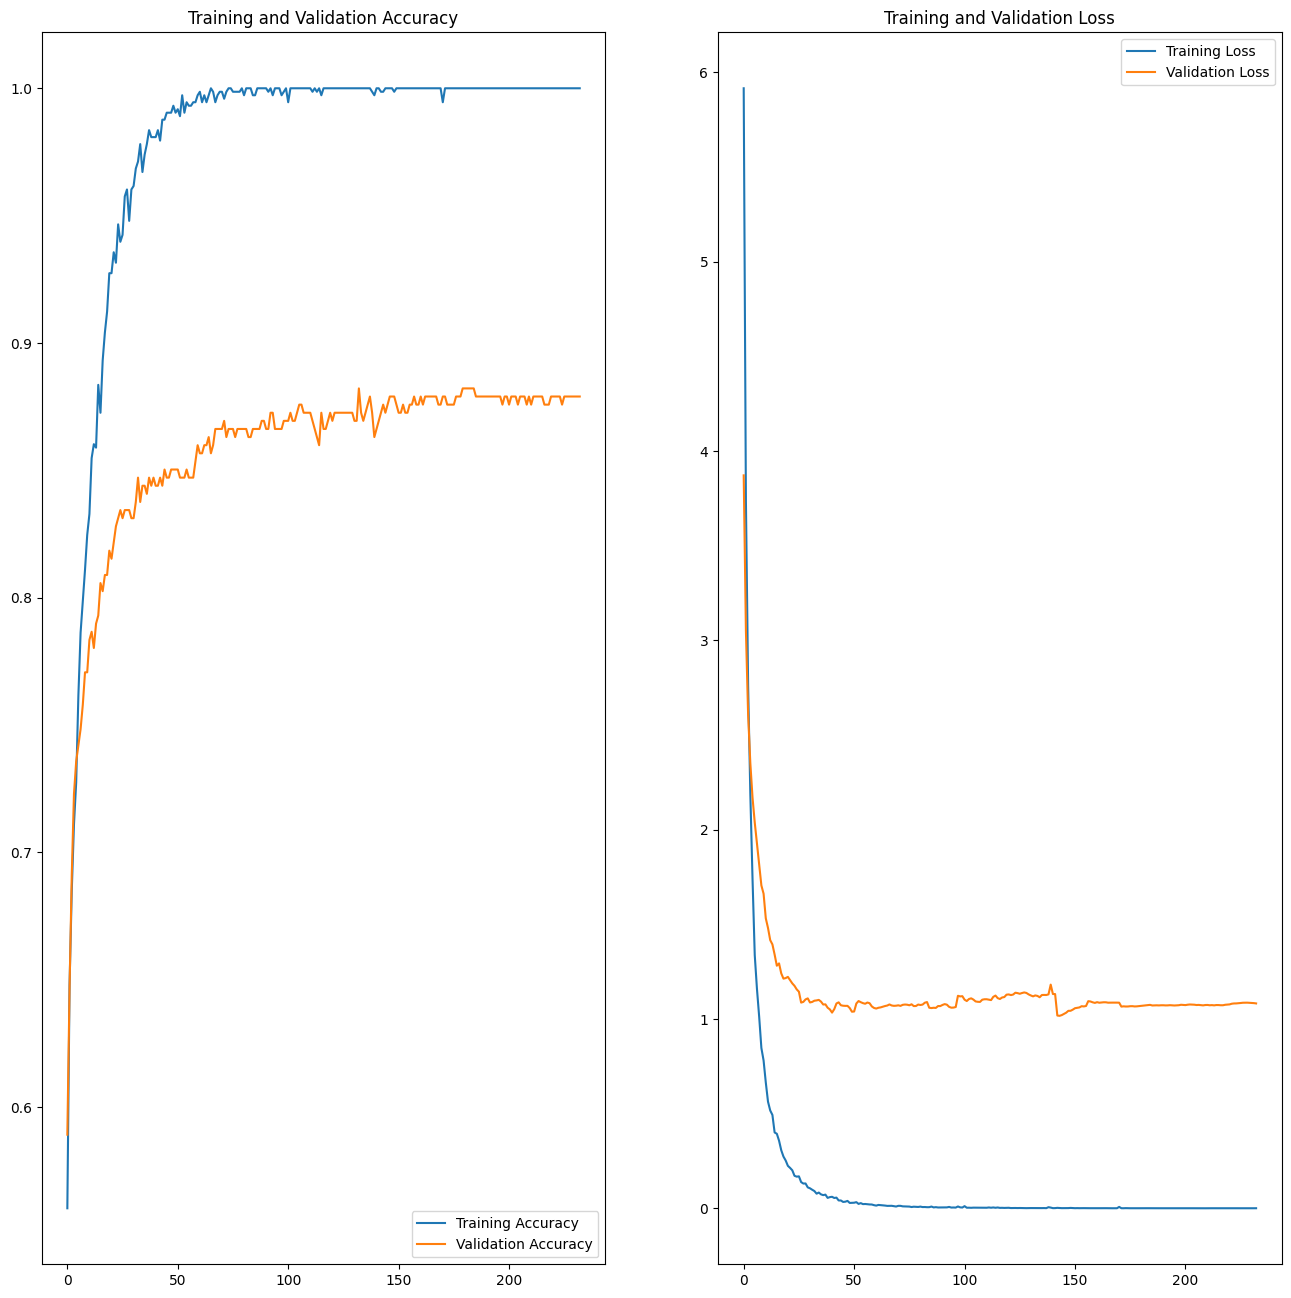

In [9]:
n_epochs = len(history.history['loss'])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(n_epochs) #change it based on epoch needed to finish building the model

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 1/10 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step

2025-12-15 19:30:57.526159: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_178', 56 bytes spill stores, 56 bytes spill loads

2025-12-15 19:30:57.550402: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_178', 56 bytes spill stores, 56 bytes spill loads



10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step


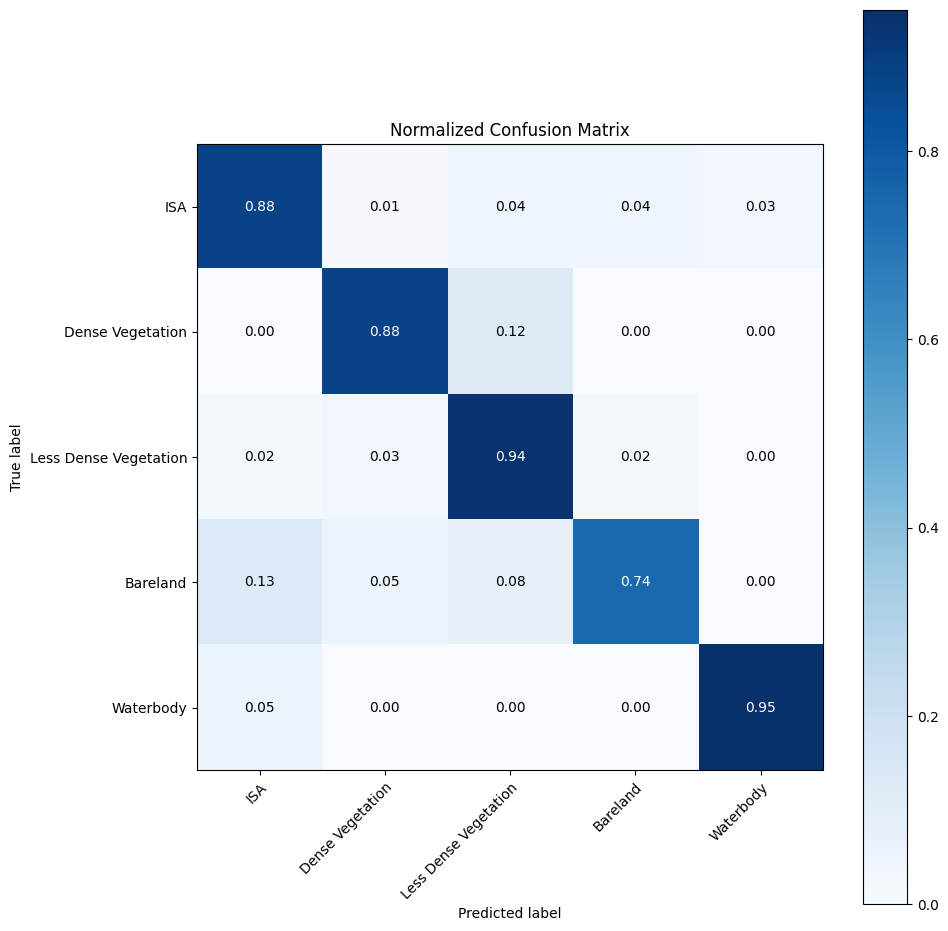

In [10]:
#confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

classes = ['ISA','Dense Vegetation','Less Dense Vegetation', 'Bareland', 'Waterbody']

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

dl_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(dl_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(dl_cm.shape[1]),
        yticks=np.arange(dl_cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title='Normalized Confusion Matrix',
        ylabel='True label',
        xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

fmt = '.2f'
thresh = dl_cm.max() / 2.
for i in range(dl_cm.shape[0]):
    for j in range(dl_cm.shape[1]):
        ax.text(j, i, format(dl_cm[i, j], fmt),
                ha="center", va="center",
                color="white" if dl_cm[i, j] > thresh else "black")
fig.tight_layout()